(c) 2025 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import base libraries
import os
import glob
import gc
import pickle

# Import JAX-related libraries
import jax
from jax import random
import jax.numpy as jnp
from numpyro.optim import Adam
import numpyro

# Import numpy for array manipulation
import numpy as np
# Import statsmodels for statistical modeling
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial
# Import scipy for special functions
import scipy as sp
# Import library to load h5ad files
import anndata as ad
# Import pandas for data manipulation
import pandas as pd
# Import scribe
import scribe
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Set plotting style
scribe.viz.matplotlib_style()

# Import colors
color_palette = scribe.viz.colors()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploratory data analysis of `scMark` datasets

In this notebook, we will perform an exploratory data analysis of the datasets
provided in the `scMark` paper. 

Let's begin by listing the files in the `scMark` dataset directory.

In [2]:
# Define data directory
DATA_DIR = "/app/data/scmark_v2/scmark_v2"

# List all files in the data directory
files = glob.glob(os.path.join(DATA_DIR, "*.h5ad"))

files

['/app/data/scmark_v2/scmark_v2/external_peng_cellres_2019_31273297.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_karlsson_sciadv_2021_34321199.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_azizi_cell_2018_29961579.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_nath_natcommun_2021_34031395.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_elyada_cancerdiscov_2019_31197017.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_zhang_procnatlacadsciusa_2021_34099557.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_bi_cancercell_2021_33711272.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_slyper_natmed_2020_32405060.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_lee_natgenet_2020_32451460.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_bassez_natmed_2021_33958794.h5ad',
 '/app/data/scmark_v2/scmark_v2/external_qian_cellres_2020_32561858.h5ad']

One aspect we care abuot is the number of cell types in each dataset. This 
information is stored in the `obs` attribute of the `AnnData` object under the
`standard_true_celltype` column. 

Let's extract this information for each dataset.

In [3]:
# Initialize dictionary to store the number of cell types
n_cell_types = {}

# Loop over the files
for file in files:
    # Load the data
    data = ad.read_h5ad(file)

    # Extract the number of cell types
    n_cell_types[file] = {
        "n_cell_types": len(data.obs["standard_true_celltype"].unique()),
        "n_cells": data.n_obs,
    }

n_cell_types

{'/app/data/scmark_v2/scmark_v2/external_peng_cellres_2019_31273297.h5ad': {'n_cell_types': 12,
  'n_cells': 10000},
 '/app/data/scmark_v2/scmark_v2/external_karlsson_sciadv_2021_34321199.h5ad': {'n_cell_types': 14,
  'n_cells': 10000},
 '/app/data/scmark_v2/scmark_v2/external_azizi_cell_2018_29961579.h5ad': {'n_cell_types': 8,
  'n_cells': 9540},
 '/app/data/scmark_v2/scmark_v2/external_nath_natcommun_2021_34031395.h5ad': {'n_cell_types': 17,
  'n_cells': 10000},
 '/app/data/scmark_v2/scmark_v2/external_elyada_cancerdiscov_2019_31197017.h5ad': {'n_cell_types': 14,
  'n_cells': 10000},
 '/app/data/scmark_v2/scmark_v2/external_zhang_procnatlacadsciusa_2021_34099557.h5ad': {'n_cell_types': 13,
  'n_cells': 10000},
 '/app/data/scmark_v2/scmark_v2/external_bi_cancercell_2021_33711272.h5ad': {'n_cell_types': 11,
  'n_cells': 10000},
 '/app/data/scmark_v2/scmark_v2/external_slyper_natmed_2020_32405060.h5ad': {'n_cell_types': 9,
  'n_cells': 10000},
 '/app/data/scmark_v2/scmark_v2/external_le

So the number of cell types ranges from 8 to 17 or so.

Another interesting aspect to look into is the distirbution of UMI counts per
cell for each dataset. Let's extract this information for each dataset.

In [17]:
# Initialize dictionary to store the number of cell types
n_umi_counts = {}

# Loop over the files
for file in files:
    # Load the data
    data = ad.read_h5ad(file)

    # Extract the number of cell types
    n_umi_counts[file] = data.X.sum(axis=1).A1

Let's now plot the ECDF of the UMI counts for each dataset.

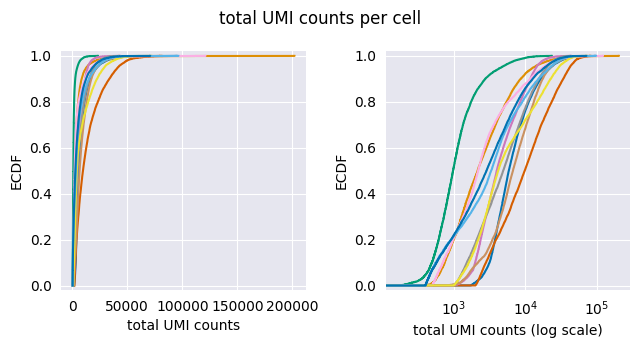

In [33]:
# Initialize figure
fig, ax = plt.subplots(1, 2,figsize=(6.5, 3.5))

# Plot the ECDF of the UMI counts for each dataset
for file in files:
    sns.ecdfplot(n_umi_counts[file], label=file, ax=ax[0])
    sns.ecdfplot(n_umi_counts[file], label=file, ax=ax[1])

# Set second plot to log scale
ax[1].set_xscale("log")

# Set plot title and labels
ax[0].set_xlabel("total UMI counts")
ax[0].set_ylabel("ECDF")

ax[1].set_xlabel("total UMI counts (log scale)")
ax[1].set_ylabel("ECDF")

# Set y-limit
ax[0].set_ylim(-0.02, 1.02)
ax[1].set_ylim(-0.02, 1.02)

# Set global title
fig.suptitle("total UMI counts per cell")

plt.tight_layout()


It seems that for all datasets, the variability in total UMI counts can be around one order of magnitude, if not more.